# DFAnalyzer Simple Example

This notebook will guide you to load a trace file generated by DFTracer and analyze the trace events using Dask.

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System imports for the notebook

In [24]:
import os
from pathlib import Path
import sys
import yaml
import json

## We add the analysis code to path so that we can run this in dev mode.

In [25]:
home = os.environ["HOME"]

with open(f"{home}/.dftracer/configuration.yaml", "r") as file:
    dft_yaml = yaml.safe_load(file)
    app_root = dft_yaml["app"]
sys.path.insert(0, app_root)

## Imports for the notebook

This may take some time as it initializes Dask.

In [26]:
# Importing DFAnalyzer
import dfanalyzer

print(dfanalyzer.__file__)
from dfanalyzer.main import (
    DFAnalyzer,
    update_dft_configuration,
    setup_logging,
    setup_dask_cluster,
    reset_dask_cluster,
)

/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/__init__.py


## Initialize DFAnalyzer Configuration

In this function, we can tune DFAnalyzer for the analysis. For example, we can tune number of workers, connect to existing dask cluster, etc.

In [27]:
def get_conditions_stormer(json_object):
    app_io_cond = (
        "__getitem__" in json_object["name"]
    )  # I/O has that application is issuing
    compute_cond = "compute" in json_object["cat"]
    io_cond = json_object["cat"] in ["POSIX", "STDIO"]
    return app_io_cond, compute_cond, io_cond

In [28]:
dask_run_dir = os.path.join(app_root, "dfanalyzer", "dask", "run_dir")
with open(os.path.join(dask_run_dir, f"scheduler_{os.getenv('USER')}.json"), "r") as f:
    dask_scheduler = json.load(f)["address"]

In [29]:
conf = update_dft_configuration(
    dask_scheduler=dask_scheduler,
    verbose=True,
    workers=4,
    time_granularity=80e6,
    log_file=f"./df_{os.getenv('USER')}.log",
    conditions=get_conditions_stormer,
)

## This methods sets up logging for DFAnalyzer.

This is needed for debugging and progress tracking. All prints seen in the following cells are configured in this method.

In [30]:
setup_logging()

## Setup dask cluster.

In this example, we use Dask Local cluster which will use multiprocessing on the same node where the notebook is running to run its workers.

**NOTE:** If your running on Remote VSCode on a cluster, you can tunnel the port and open it locally.

In [31]:
setup_dask_cluster()

[INFO] [18:01:12] Initialized Client with 144 workers and link http://134.9.71.28:8787/status [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:768]


On clicking the link, you will see a daskboard like this. [Dask Daskboard Image](images/dask-dashboard-load.png)

## Reset Dask Cluster

In case you have an error and want to clean the cluster for fresh analysis. You can run this.

In [32]:
reset_dask_cluster()

[INFO] [18:01:21] Restarting all workers [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:760]


## Load the DFAnalyzer Trace

The DFAnalyzer class take a regex string as input. For example, "{app_root}/examples/dfanalyzer/*.pfw.gz"

In [33]:
analyzer = DFAnalyzer(f"/p/lustre3/iopp/dftracer-traces/v1.0.5-develop/corona/montage-2mass-2deg_16_48_20240927/montage-2mass-2deg_16_48_20240927-RAW/montage-mAdd-*-preload.pfw.gz")

[INFO] [18:01:39] Created index for 3 files [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:428]
[INFO] [18:01:39] Total size of all files are <dask.bag.core.Item object at 0x15549fdf9a90> bytes [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:430]
[INFO] [18:01:41] Loading 170 batches out of 3 files and has 2755638 lines overall [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:443]
[INFO] [18:01:50] Loaded events [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:510]
[INFO] [18:01:50] Loaded plots with slope threshold: 45 [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:516]


## Analyze the events

1. The dask dataframe is stored at `analyzer.events`. 
2. We can run dask queries on this dataframe.

In [34]:
analyzer.events.head()

,name,cat,type,pid,tid,ts,te,dur,tinterval,trange,compute_time,io_time,app_io_time,total_time,fhash,phase,size,hash,hhash,value
4,start,dftracer,0,1967827,1967827,35894640,35894640,0,<NA>,0,<NA>,<NA>,<NA>,0,<NA>,0,<NA>,<NA>,13118,<NA>
6,fopen64,STDIO,0,1967827,1967827,35898267,35898831,564,<NA>,0,<NA>,564,<NA>,564,17912,2,<NA>,<NA>,13118,<NA>
7,fread,STDIO,0,1967827,1967827,35898845,35899078,233,<NA>,0,<NA>,233,<NA>,233,17912,2,<NA>,<NA>,13118,<NA>
8,fclose,STDIO,0,1967827,1967827,35899088,35899392,304,<NA>,0,<NA>,304,<NA>,304,17912,2,<NA>,<NA>,13118,<NA>
9,fopen64,STDIO,0,1967827,1967827,35899420,35899720,300,<NA>,0,<NA>,300,<NA>,300,17912,2,<NA>,<NA>,13118,<NA>


### Summary 

DFAnalyzer supports a summary utility that gives a brief summary of the job and its I/O access behavior.

In [35]:
items = analyzer.summary()
items

[INFO] [18:01:54] Total number of events in the workload are 2753568 [/usr/workspace/iopp/kogiou1/dftracer/dfanalyzer/main.py:622]


╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 3                                                                                     │
│                ├── Processes: 3                                                                                 │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 0                                                                               │
│                │   └── I/O: 3                                                                                   │
│                └── Events Recorded: 3M                                                                          │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 2027                                                                                  │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 122.444 sec                                                                  │
│                │   └── Overall I/O: 102.082 sec                                                                 │
│                └── Metrics by function                                                                          │
│                    ├── Function       |count |                  size                   |                        │
│                    ├──                |      |min   |25    |mean  |median|75    |max   |                        │
│                    ├── fopen64        |4K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── fread          |2M    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── fclose         |4K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── __xstat64      |3     |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── fseek          |3     |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── remove         |6     |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    └── fwrite         |259K  |NA    |nan   |nan   |NA    |nan   |NA    |                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Timeline plots

We support two timeline plots:
1. how I/O time and I/O bandwidth changes over time.
2. how transfer size changes over time.

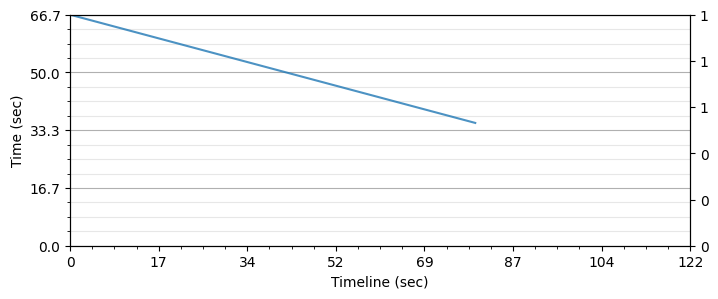

In [14]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit="gb",
    figsize=(8, 3),
    line1_label="POSIX I/O Time",
    line2_label="POSIX I/O Bandwidth",
    time_col="io_time",
    x_num_ticks=8,
    y_num_ticks=5,
)

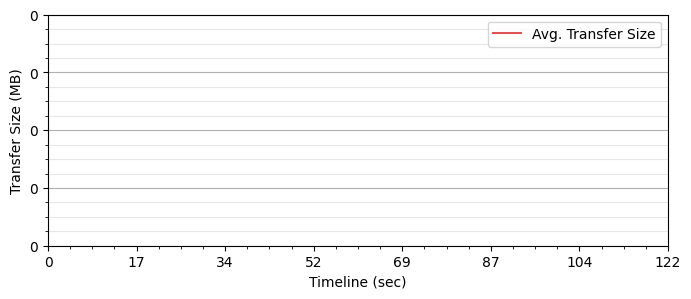

In [15]:
fig, ax = analyzer.plots.xfer_size_timeline(
    figsize=(8, 3),
    unit="mb",
    x_num_ticks=8,
)

[INFO] [18:02:14] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [/usr/workspace/iopp/kogiou1/venvs/corona-dfanalyzer/lib/python3.9/site-packages/matplotlib/category.py:223]
[INFO] [18:02:14] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [/usr/workspace/iopp/kogiou1/venvs/corona-dfanalyzer/lib/python3.9/site-packages/matplotlib/category.py:223]
[INFO] [18:02:14] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [/usr/workspace/iopp/kogiou1/venvs/corona-dfanalyzer/lib/python3.9/site-packages/matplotlib/category.py:223]
[INFO] [18:02:15] Using categorical units to plot

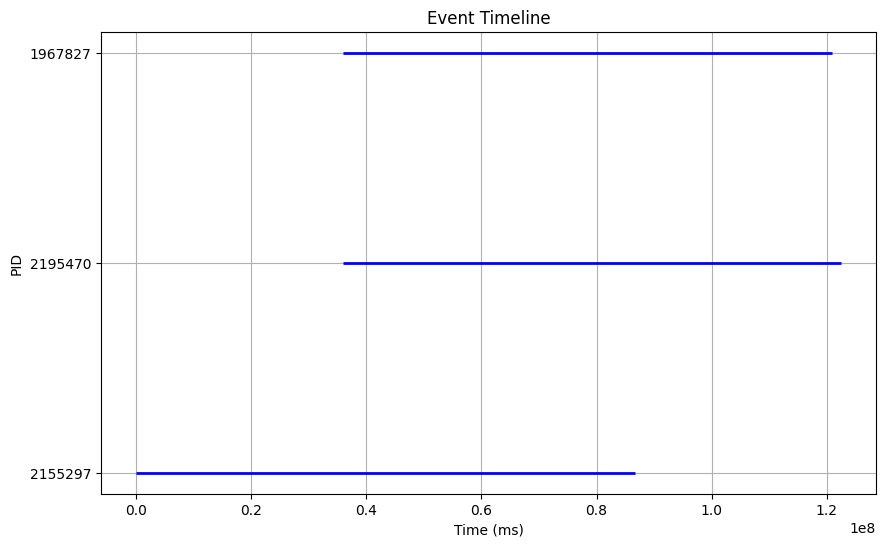

In [37]:

analyzer.plots.create_event_timeline(analyzer.events)


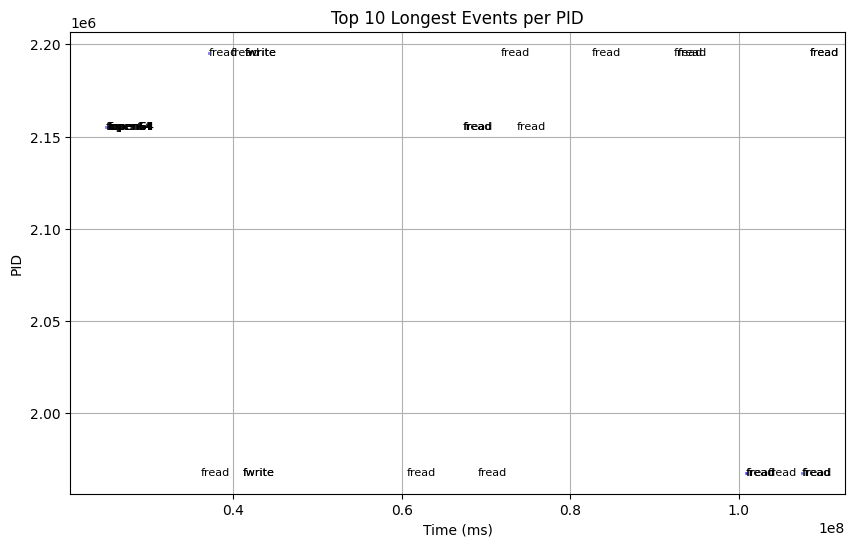

In [40]:
analyzer.plots.top_10_longest_events(analyzer.events)